# Introduction to Quantum Computation
# Solutions to Problem Set 4  

Applied Mathematics and Computer Science  
Presented by: Oscar Velasco  
Presented to: Julián Jiménez  
Date: 03/Nov/2020

In [48]:
# Necessary Libraries

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.quantum_info import Statevector
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
import math
import cmath
import random
import numpy as np

%matplotlib inline

The qiskit version used to this task is:

In [9]:
qiskit.__version__

'0.15.2'

In [10]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.2',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.1'}

# Problem 1 [P]

**Quantum Teleportation**. First implement the standart version and then consider defining the entangled state shared by Alice and Bob with any other entangled state of the Bell basis.

## Solution

Remember that, you have to take account the **standard** protocol stablished by Alice and Bob. Depending on the classical information that Alice sends, Bob will or will not apply a process to retrieve the quantum information. The protocol us, if Alice sends:

$$
00 \rightarrow \text{Bob do nothing}
$$  
$$
01 \rightarrow \text{Bob Apply X gate}
$$  
$$
10 \rightarrow \text{Bob Apply Z gate}
$$  
$$
01 \rightarrow \text{Bob Apply ZX gate}
$$  

And now, observe the implementation of the standard protocol:

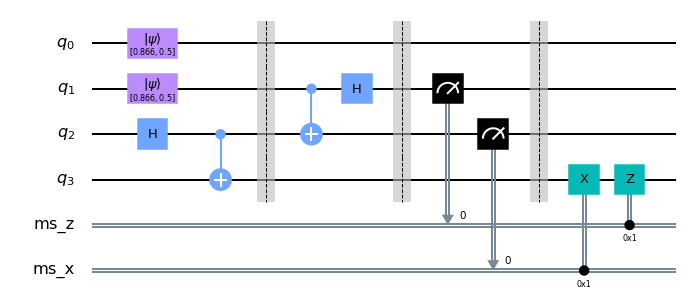

In [11]:
# Initial State \psi
alpha = math.sqrt(3)/2
beta = 1/2
init_state_tp = [alpha, beta]

qr = QuantumRegister(4, name = 'q')
ms_z = ClassicalRegister(1, name = 'ms_z')
ms_x = ClassicalRegister(1, name = 'ms_x')
tp_circuit = QuantumCircuit(qr, ms_z, ms_x)
tp_circuit.initialize(init_state_tp, 0)
tp_circuit.initialize(init_state_tp, 1)

# Bell State x = 0 and y = 0
tp_circuit.h(2)
tp_circuit.cx(2, 3)
tp_circuit.barrier()

# Apply gates
tp_circuit.cx(1, 2)
tp_circuit.h(1)
tp_circuit.barrier()

# Do measurements
tp_circuit.measure(1, 0)
tp_circuit.measure(2, 1)
tp_circuit.barrier()

# Implement protocol
tp_circuit.x(3).c_if(ms_x, 1)
tp_circuit.z(3).c_if(ms_z, 1)

tp_circuit.draw('mpl')

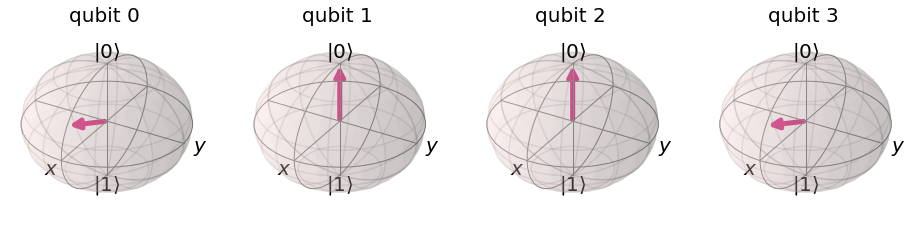

In [12]:
simulator_tp = Aer.get_backend('statevector_simulator')
tp_states = execute(tp_circuit, simulator_tp).result().get_statevector()
plot_bloch_multivector(tp_states)

Notice in the previous graphic, that the initial state sended by Alice (qubit 0) is the same state Bob received (qubit 3).
The Quantum Teleportation was a success!

$$$$

Now, consider the same problem, but using the other 3 entangled states of the Bell basis. Observe the following generealized quantum teleportation circuit for any Bell State:

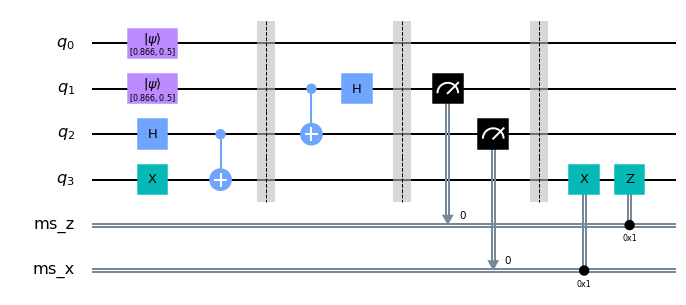

In [13]:
# Initial State \psi
alpha = math.sqrt(3)/2
beta = 1/2
init_state_tp = [alpha, beta]

qr = QuantumRegister(4, name = 'q')
ms_z = ClassicalRegister(1, name = 'ms_z')
ms_x = ClassicalRegister(1, name = 'ms_x')
tp_circuit = QuantumCircuit(qr, ms_z, ms_x)
tp_circuit.initialize(init_state_tp, 0)
tp_circuit.initialize(init_state_tp, 1)

# Bell State B_xy
x, y = 0, 1
if(x == 1):
    tp_circuit.x(2)
if(y == 1):
    tp_circuit.x(3)
    
tp_circuit.h(2)
tp_circuit.cx(2, 3)
tp_circuit.barrier()

# Apply gates
tp_circuit.cx(1, 2)
tp_circuit.h(1)
tp_circuit.barrier()

# Do measurements
tp_circuit.measure(1, 0)
tp_circuit.measure(2, 1)
tp_circuit.barrier()

# Implement protocol
tp_circuit.x(3).c_if(ms_x, 1)
tp_circuit.z(3).c_if(ms_z, 1)

tp_circuit.draw('mpl')

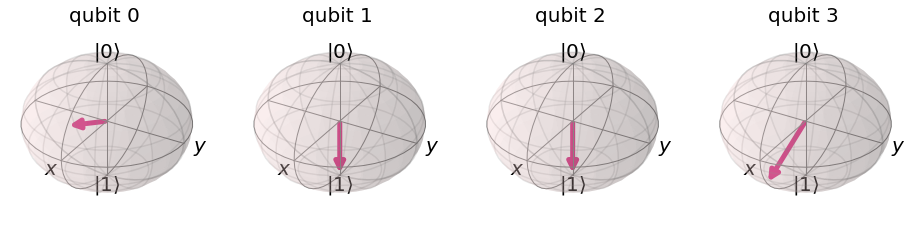

In [14]:
simulator_tp = Aer.get_backend('statevector_simulator')
tp_states = execute(tp_circuit, simulator_tp).result().get_statevector()
plot_bloch_multivector(tp_states)

In any of the cases that one of the 3 states other than $|B_{00}\rangle$ is used, the final state (qubit 3) is oriented towards another direction that does not correspond to the state $|\psi\rangle$ that must be recovered (qubit 1). After try and failure, the solution for quantum teleportation to work regardless of the Bell State used in the protocol, is the following:

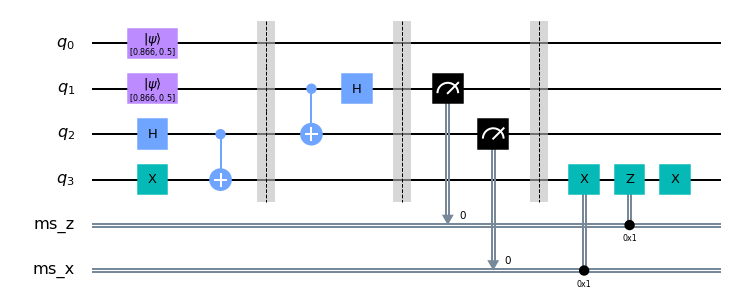

In [15]:
if(x == 1):
    tp_circuit.z(3)
if(y == 1):
    tp_circuit.x(3)
    
tp_circuit.draw('mpl')

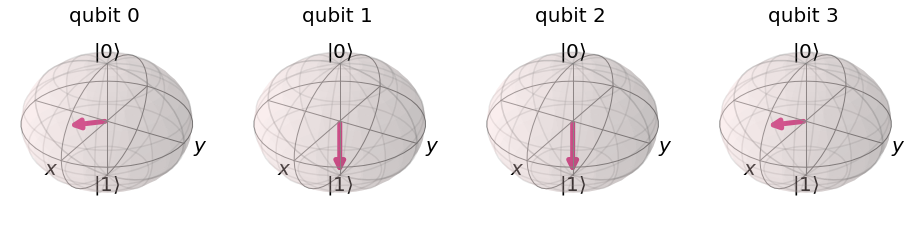

In [16]:
simulator_tp = Aer.get_backend('statevector_simulator')
tp_states = execute(tp_circuit, simulator_tp).result().get_statevector()
plot_bloch_multivector(tp_states)

The previous figure shows the correction of the state that Bob wants to obtain.

$$$$

Now, we are going to send the execution of the standard quantum teleportation circuit to the IBM Quantum Computers. 
For this, the circuit that we already have implemented at the beginning must be slightly modified, in order to respect certain restrictions when sending the execution.

**Theorem (*Principle of deferred measurement*):** Measurements can always be moved from an intermediate stage of a quantum circuit to the end of the circuit; if the measurement results are used at any stage of the circuit the the classically controlled operations can be replaced by conditional quantum operations (and backwards). 

In short, any measurement taken along the circuit can be postposed until the end of this. In this way, the modified circuit is the following: 

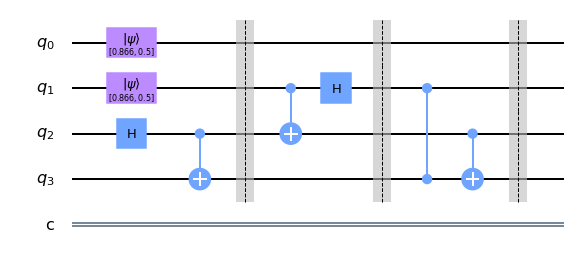

In [17]:
# Initial State \psi
alpha = math.sqrt(3)/2
beta = 1/2
init_state_tp = [alpha, beta]

tp_circuit = QuantumCircuit(4, 1)
tp_circuit.initialize(init_state_tp, 0)
tp_circuit.initialize(init_state_tp, 1)

# Bell State B_00
tp_circuit.h(2)
tp_circuit.cx(2, 3)
tp_circuit.barrier()

# Apply gates
tp_circuit.cx(1, 2)
tp_circuit.h(1)
tp_circuit.barrier()

# Implement protocol
tp_circuit.cz(1, 3)
tp_circuit.cx(2, 3)

# Do measurements
tp_circuit.barrier()

tp_circuit.draw('mpl')

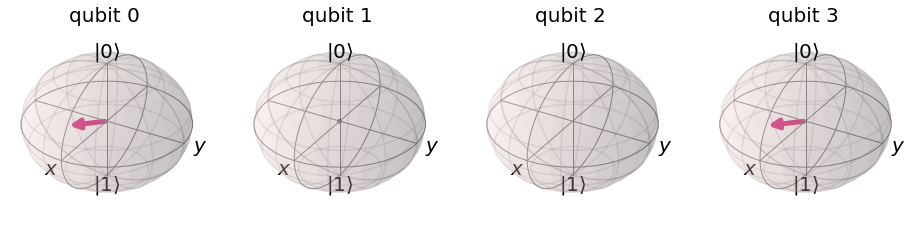

In [18]:
simulator_tp = Aer.get_backend('statevector_simulator')
tp_states = execute(tp_circuit, simulator_tp).result().get_statevector()
plot_bloch_multivector(tp_states)

Note that the quantum teleportation continues to function properly after changes (state in qubit 0 is equal to state in qubit 3).
And finally, let's run the circuit on a Real Quantum Computer:

In [19]:
IBMQ.save_account('4333ba0445a2dec45dd7d7ad62e0ae3e18587682cc7557212a3c89863593d0572de405cf0b3b857109c4c08040133caf268c7815d6d6f7d2e036a8d67385c97d')

configrc.store_credentials:WARNING:2020-11-13 17:51:46,807: Credentials already present. Set overwrite=True to overwrite.


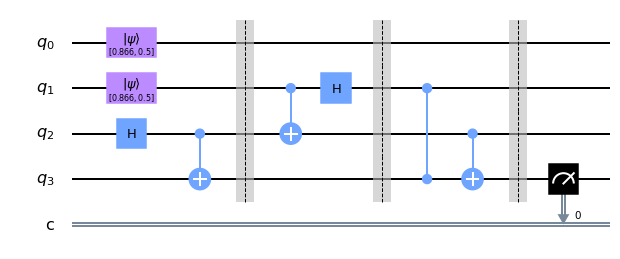

In [20]:
tp_circuit.measure(3, 0)
tp_circuit.draw('mpl')

In [21]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')
provider.backends()

/home/oscarvch03/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [139]:
backend = least_busy(provider.backends(filters = lambda b: b.configuration().n_qubits >= 4 
                                       and not b.configuration().simulator 
                                       and b.status().operational == True))
job_exp = execute(tp_circuit, backend = backend, shots = 8192)
print(backend)
job_monitor(job_exp)

ibmq_ourense
Job Status: job has successfully run


{'0': 5864, '1': 2328}


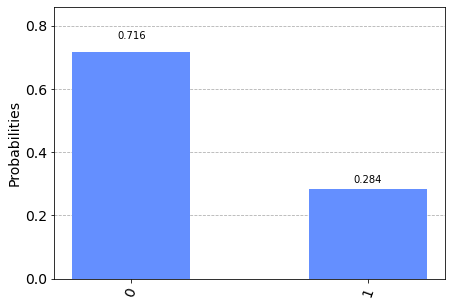

In [141]:
exp_result = job_exp.result()
exp_meas_res = exp_result.get_counts(tp_circuit)
print(exp_meas_res)
plot_histogram(exp_meas_res)

Notice that, the data of measurement matches the initial state $|\psi\rangle$ that was teleported. Therefore, the Quantum Teleportation was a success again!

--------------------------------------------------------------------------------------------

# Problem 2 [P]

**Superdense Coding**. Code the standard version first; then modify your quantum circuit to simulate the action of Eve, and show that this protocol is a secure quantum communication channel.

## Solution

The protocol that Alice and Bob have to send and receive information respectly, consists in that according to the message that Alice wants to send, it is encoded, or rather, the initial Bell state $|B_{00}\rangle$ is sent, or it is transformed according to the following rules:

$$
\text{Msg: } 00 \rightarrow \text{Apply Gate: } I \rightarrow \text{Resulting State: } |B_{00}\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$  
$$
\text{Msg: } 01 \rightarrow \text{Apply Gate: } Z \rightarrow \text{Resulting State: } |B_{10}\rangle = \frac{|00\rangle - |11\rangle}{\sqrt{2}}
$$  
$$
\text{Msg: } 10 \rightarrow \text{Apply Gate: } X \rightarrow \text{Resulting State: } |B_{01}\rangle = \frac{|01\rangle + |10\rangle}{\sqrt{2}}
$$  
$$
\text{Msg: } 11 \rightarrow \text{Apply Gate: } iY = ZX \rightarrow \text{Resulting State: } |B_{11}\rangle = \frac{|01\rangle - |10\rangle}{\sqrt{2}}
$$  

And to decode and retrieve the message sent by Alice, Bob applies the controlled-not gate, followed by a Hadamard in the first qubit, and then he takes the respective measurements. Observe the entire procedure above in the following program:

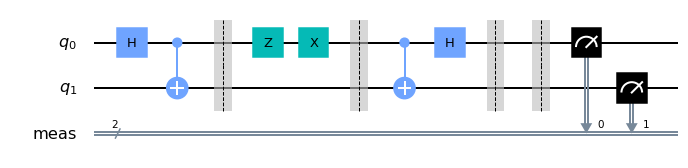

In [22]:
# Initialize the quantum circuit
sd_cod_circuit = QuantumCircuit(2)

# Initial Bell State B_00
sd_cod_circuit.h(0)
sd_cod_circuit.cx(0, 1)
sd_cod_circuit.barrier()

# Message to send
msg = '11'

# Encode the message
if msg == '00':
    sd_cod_circuit.i(0)
elif msg == '01':
    sd_cod_circuit.z(0)
elif msg == '10':
    sd_cod_circuit.x(0)
elif msg == '11':
    sd_cod_circuit.z(0)
    sd_cod_circuit.x(0)    
else:
    print("Invalid message, sending '00'.")
sd_cod_circuit.barrier()

# Decode the message
sd_cod_circuit.cx(0, 1)
sd_cod_circuit.h(0)
sd_cod_circuit.barrier()

# Measurement
sd_cod_circuit.measure_all()
sd_cod_circuit.draw('mpl')

{'11': 1024}


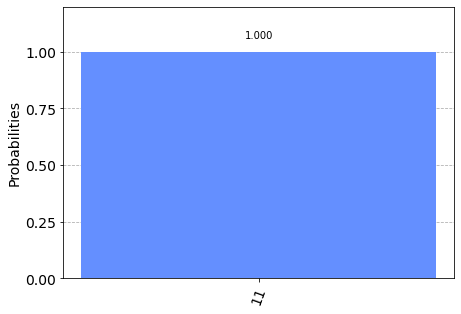

In [23]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(sd_cod_circuit, backend, shots = 1024)
sim_result = job_sim.result()

meas_result = sim_result.get_counts(sd_cod_circuit)
print(meas_result)
plot_histogram(meas_result)

Note that the graphic above shows that Bob indeed retrieves the message sent by Alice!

$$$$

Suppose that an attacker, (Eva) wants to know what is the message that Alice sent to Bob, but she does not know the encoding and decoding protocol that they use. The only idea Eva can come up with is to measure on the channel, before Bob decodes the message. For this Eva must define a positive operator that respects all the measurement principles. Unfortunately for her, when measuring with this operator, she will obtain the same result no matter that message Alice sent, that is, the expected value of applying this operator will be the same on any of the Bell states resulting from the encoding (Quiz 2). Therefore **the quantum communication channel** used by Alice and Bob **is secure**.

$$$$

And finally, we are going to execute the Superdense Coding Circuit on a real quantum computer:

In [24]:
provider = IBMQ.get_provider(hub = 'ibm-q')
backend = least_busy(provider.backends(filters = lambda b: b.configuration().n_qubits >= 2 
                                       and not b.configuration().simulator 
                                       and b.status().operational == True))
job = execute(sd_cod_circuit, backend = backend, shots = 256)
print("least busy backend: ", backend)

least busy backend:  ibmq_ourense


In [25]:
job_monitor(job)

Job Status: job has successfully run


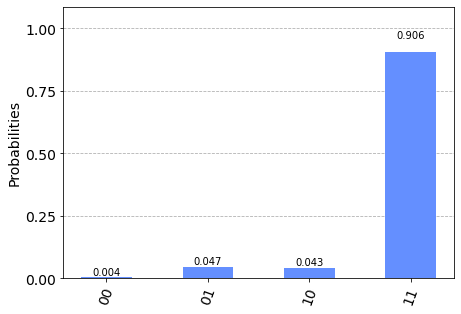

In [26]:
result = job.result()
plot_histogram(result.get_counts(sd_cod_circuit))

Note that the results given by the quantum computer have more separate probabilities, but even so, the larger of these agree with the message that Alice sends to Bob.

--------------------------------------------------------------------------------------------

#  Problem 3 [P]

**Deutsch-Jozsa Algorithm**. Implement this quantum algorithm for when the $n$-qubit query register is composed of $n = 1$, $2$, and $4$ qubits. Notice the $n = 1$ case corresponds to Deutsch's algorithm.

## Solution

In the Deutsch-Jozsa problem we are given a quantum function (which for us is a black box) $f(x_{1}, x_{2}, ..., x_{n})$ that takes $n$ input bits $x_{1}, x_{2}, ..., x_{n}$ and returns a binary value $f(x_{1}, x_{2}, ..., x_{n})$. We know that the function is constant ($0$ on all inputs or $1$ on all inputs) or balanced (returns $1$ for half of the inputs and $0$ for the other half); the problem is then to determine how the function is (constant or balanced) applying inputs to the black box and observing its output.



Consider the following generalized implementation of the Deutsch-Jozsa algorithm for $n$ qubits:

In [108]:
def deutsch_jozsa_oracle(function_case, n):
    oracle_qc = QuantumCircuit(n + 1)
    
    if function_case == 'balanced':
        b = np.random.randint(1, 2 ** n)
        b_str = format(b, '0' + str(n) + 'b')
        
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
                
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
            
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
    
    if function_case == 'constant':
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
        
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = 'Oracle'
    return oracle_gate, oracle_qc

In [109]:
def deutsch_jozsa_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n + 1, n)
    
    dj_circuit.x(n)
    dj_circuit.barrier()
    dj_circuit.h(n)
    
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    dj_circuit.barrier()
    dj_circuit.append(oracle, range(n + 1))
    dj_circuit.barrier()
    
    for qubit in range(n):
        dj_circuit.h(qubit)
        
    dj_circuit.barrier()
        
    for i in range(n):
        dj_circuit.measure(i, i)
        
    return dj_circuit    

### Implementation for $n = 1$ qubit

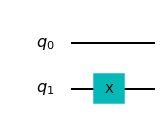

In [130]:
# Initilize quantum oracle
n = 1
oracle_gate, oracle_qc = deutsch_jozsa_oracle('constant', n)
oracle_qc.draw('mpl')

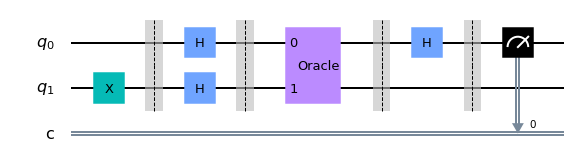

In [131]:
dj_circuit = deutsch_jozsa_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')

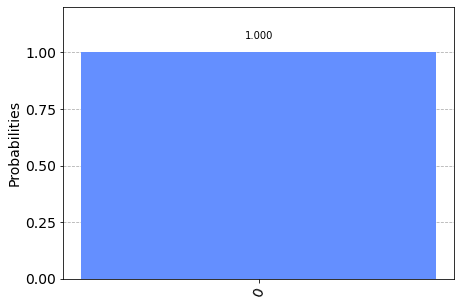

In [132]:
backend = BasicAer.get_backend('qasm_simulator')
results = execute(dj_circuit, backend = backend, shots = 1024).result()
answer = results.get_counts()
plot_histogram(answer)

### Implementation for $n = 2$ qubits

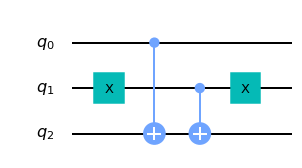

In [133]:
# Initilize quantum oracle
n = 2
oracle_gate, oracle_qc = deutsch_jozsa_oracle('balanced', n)
oracle_qc.draw('mpl')

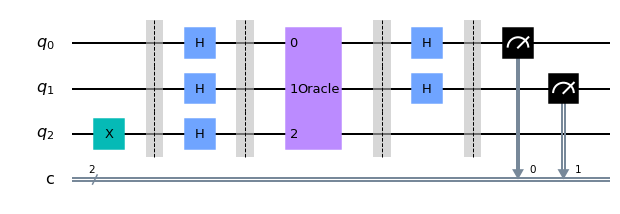

In [134]:
dj_circuit = deutsch_jozsa_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')

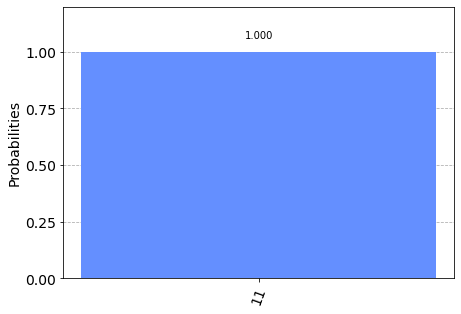

In [135]:
backend = BasicAer.get_backend('qasm_simulator')
results = execute(dj_circuit, backend = backend, shots = 1024).result()
answer = results.get_counts()
plot_histogram(answer)

And now, we are going to execute this last circuit ($n = 2$) on a real quantum computer:

In [136]:
provider = IBMQ.get_provider(hub = 'ibm-q')
backend = least_busy(provider.backends(filters = lambda b: b.configuration().n_qubits >= (n + 1) 
                                       and not b.configuration().simulator 
                                       and b.status().operational == True))
print("least busy backend: ", backend)

least busy backend:  ibmq_ourense


In [137]:
job = execute(dj_circuit, backend = backend, shots = 1024, optimization_level = 3)
job_monitor(job, interval = 2)

Job Status: job has successfully run


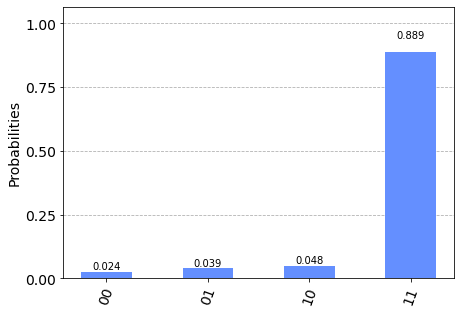

In [140]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

### Implementation for $n = 4$ qubits

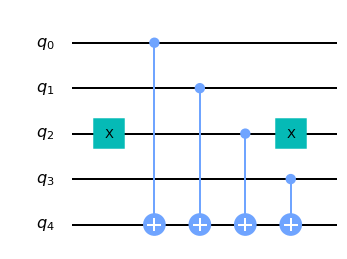

In [124]:
# Initilize quantum oracle
n = 4
oracle_gate, oracle_qc = deutsch_jozsa_oracle('balanced', n)
oracle_qc.draw('mpl')

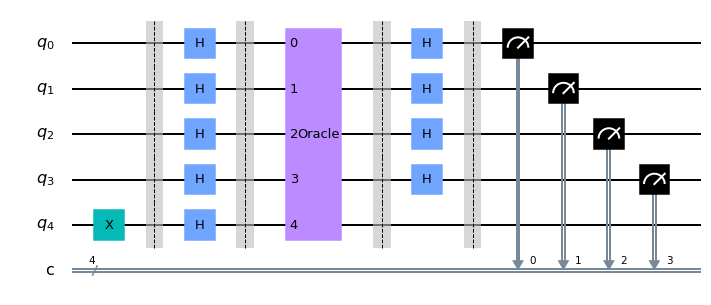

In [125]:
dj_circuit = deutsch_jozsa_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')

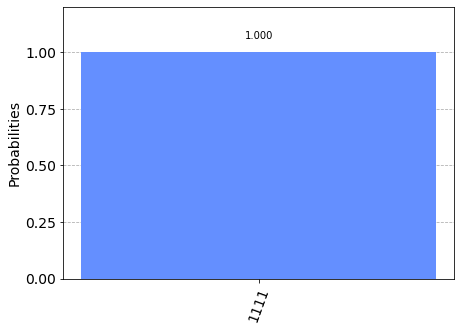

In [126]:
backend = BasicAer.get_backend('qasm_simulator')
results = execute(dj_circuit, backend = backend, shots = 1024).result()
answer = results.get_counts()
plot_histogram(answer)

And now, we are going to execute this last circuit ($n = 4$) on a real quantum computer:

In [142]:
provider = IBMQ.get_provider(hub = 'ibm-q')
backend = least_busy(provider.backends(filters = lambda b: b.configuration().n_qubits >= (n + 1) 
                                       and not b.configuration().simulator 
                                       and b.status().operational == True))
print("least busy backend: ", backend)

least busy backend:  ibmq_ourense


In [128]:
job = execute(dj_circuit, backend = backend, shots = 1024, optimization_level = 3)
job_monitor(job, interval = 2)

Job Status: job has successfully run


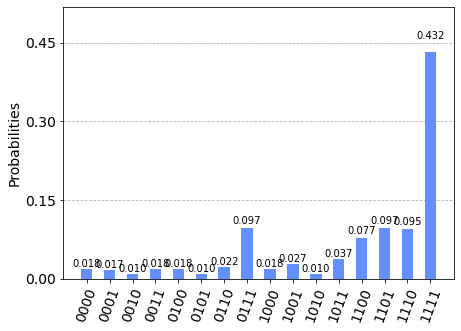

In [129]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

--------------------------------------------------------------------------------------------

## Bibliography  

[1] **Learn Quantum Computation Using Qiskit**.  

**Contributors**: Abraham Asfaw, Luciano Bello, Yael Ben-Haim, Sergey Bravyi, Lauren Capelluto, Almudena Carrera Vazquez, Jack Ceroni, Richard Chen, Albert Frisch, Jay Gambetta, Shelly Garion, Leron Gil, Salvador De La Puente Gonzalez, Francis Harkins, Takashi Imamichi, David McKay, Antonio Mezzacapo, Zlatko Minev, Ramis Movassagh, Giacomo Nannicni, Paul Nation, Anna Phan, Marco Pistoia, Arthur Rattew, Joachim Schaefer, Javad Shabani, John Smolin, Kristan Temme, Madeleine Tod, Stephen Wood, James Wootton.  

**Link**: https://qiskit.org/textbook/preface.html  

[2]  **Quantum Computation and Quantum Information**, 10th Edition, Michael A. Nielsen & Isaac L. Chuang, 2010, Cambridge University Press.